In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
import pdb
%matplotlib inline

In [14]:
def bottomHistogram(img):
    bottom_half = img[img.shape[0]//2:, :]
    hist = np.sum(bottom_half, axis=0)
    return hist

def getTwoPeaks(histogram):
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base, rightx_base

def getWindow(x_center, y_center, window_width=200, window_height=80):
    top = y_center - window_height / 2
    bottom = y_center + window_height / 2
    left = x_center - window_width / 2
    right = x_center + window_width / 2
    return top, bottom, left, right

def thresh2Binary(inp, thresh_min, thresh_max):
    binary = np.zeros_like(inp)
    binary[(thresh_min <= inp) & (inp <= thresh_max)] = 1
    return binary

def scaledThresh2Binary(inp, thresh_min, thresh_max):
    scaled = np.uint8(inp / np.max(inp) * 255)
    return thresh2Binary(scaled, thresh_min, thresh_max)

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # thresh=(20, 100)
    if orient == 'x':
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        raise "AugumentError"
    return scaledThresh2Binary(sobel, thresh[0], thresh[1])

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    # sobel_kernel=9, mag_thresh=(30, 100)
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    magnitude = np.sqrt(np.square(sobelx) + np.square(sobely))
    return scaledThresh2Binary(magnitude, thresh[0], thresh[1])

def dir_thresh(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # sobel_kernel=15, thresh=(0.7, 1.3)
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    return thresh2Binary(direction, thresh[0], thresh[1])

def hls_thresh(image, channel='h', thresh=(0, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    if channel == 'h':
        c = 0
    elif channel == 'l':
        c = 1
    elif channel == 's':
        c = 2
    else:
        raise "ArgumentError"
    return thresh2Binary(hls[:,:,c], thresh[0], thresh[1])

def combineBinary(binaryImages = [], show=False):
    binary = np.zeros_like(binaryImages[0])
    for bImg in binaryImages:
        binary[bImg == 1] = 1
    if show:
        plt.figure()
        plt.title("combineBinary")
        plt.imshow(binary)
    return binary

class YellowDetector:
    def __init__(self, thresh_min=155, thresh_max=255):
        self.min = thresh_min
        self.max = thresh_max
    def __call__(self, image, show=False):
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        result = thresh2Binary(lab[:,:,2], self.min, self.max)
        if show:
            plt.figure()
            plt.title("YellowDetector")
            plt.imshow(result)
        return result

class SobelXDetector:
    def __init__(self, thresh_min=60, thresh_max=200):
        self.min = thresh_min
        self.max = thresh_max
    def __call__(self, image, show=False):
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=15)
        result = scaledThresh2Binary(sobel, self.min, self.max)

# not used
class CannyEdgeDetector:
    def __init__(self, thresh_min=50, thresh_max=150):
        self.min = thresh_min
        self.max = thresh_max
    def __call__(self, image, show=False):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        result = cv2.Canny(gray, self.min, self.max)
        if show:
            plt.figure()
            plt.title("CannyEdgeDetector")
            plt.imshow(result)
        return result

class Undistortor:
    def __init__(self, image_dir='./camera_cal/', nx=9, ny=6):
        self.mtx, self.dist = self.calibrateCamera(image_dir, nx, ny)
        
    def __call__(self, image, show=False):
        result = cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
        if show:
            plt.figure()
            plt.title("Undistortor")
            plt.imshow(result)
        return result

    def calibrateCamera(self, chessboard_image_dir, nx, ny):
        image_points = []
        object_points = []
        mapped_corners = np.zeros([nx * ny, 3], np.float32)
        mapped_corners[:,:2] = np.mgrid[:nx, :ny].T.reshape([-1, 2])

        chessboard_image_paths = glob.glob(os.path.join(chessboard_image_dir, "*"))
        for chessboard_image_path in chessboard_image_paths:
            chessboard_image = cv2.imread(chessboard_image_path)
            gray_chessboard_image = cv2.cvtColor(chessboard_image, cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(gray_chessboard_image, (nx, ny), None)
            if ret:
                object_points.append(mapped_corners)
                image_points.append(corners)

        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, chessboard_image.shape[1::-1], None, None)
        return mtx, dist

class WhiteDetector:
    def __init__(self, sensitivity=35):
        self.lower_white = np.array([0,0,255-sensitivity])
        self.upper_white = np.array([255,sensitivity,255])
        
    def __call__(self, image, show=False):
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(hsv, self.lower_white, self.upper_white)
        result_color = cv2.bitwise_and(image, image, mask=mask)
        result_binary = self.cvt2Binary(result_color)
        if show:
            plt.figure()
            plt.title("WhiteDetector")
            plt.imshow(result_binary)
        return result_binary
    
    def cvt2Binary(self, image):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        binary = scaledThresh2Binary(image, 10, 255)
        return binary

class Warper:
    def __init__(self, 
                 src=[[256, 675], [1024, 675], [740, 487], [540, 487]], 
                 dst=[[256, 720], [1024, 720], [1024, 200], [256, 200]]):
        # src, dst chosen mannually, maybe reference other settings
        self.M = cv2.getPerspectiveTransform(np.float32(src), np.float32(dst))
        self.Minv = cv2.getPerspectiveTransform(np.float32(dst), np.float32(src))
    def warp(self, image, show=False):
        result = cv2.warpPerspective(image, self.M, image.shape[1::-1])
        if show:
            plt.figure()
            plt.title("Warper")
            plt.imshow(result)
        return result
    def inverseWarp(self, image, show=False):
        result = cv2.warpPerspective(image, self.Minv, image.shape[1::-1])
        if show:
            plt.figure()
            plt.title("WarperInverse")
            plt.imshow(result)
        return result

class LineFinder:
    def __init__(self, window_height=80, window_width=200, n_recenter=50, show=False):
        self.w_height = 80
        self.w_width = 200
        self.n_recenter = 50
        self.show = show
        
    def __call__(self, warped_binary, left_line_coef=None, right_line_coef=None):
        self.image_width = warped_binary.shape[1]
        nonzero_x, nonzero_y = self.getNonzero(warped_binary)
        left_center_x, right_center_x = self.bottomeHistogramPeak(warped_binary)
        center_y = warped_binary.shape[0] - self.w_height // 2
        
        if left_line_coef is not None and right_line_coef is not None:
            left_line_points = self.getLinePointsGivenLine(nonzero_x, nonzero_y, left_line_coef, center_y)
            right_line_points = self.getLinePointsGivenLine(nonzero_x, nonzero_y, right_line_coef, center_y)
            
        else:
            left_line_points = self.getLinePointsGivenCenter(nonzero_x, nonzero_y, left_center_x, center_y)
            right_line_points = self.getLinePointsGivenCenter(nonzero_x, nonzero_y, right_center_x, center_y)
            
        return left_line_points, right_line_points
        
    def getNonzero(self, warped_binary):
        nonzero = warped_binary.nonzero()
        nonzero_y = np.array(nonzero[0])
        nonzero_x = np.array(nonzero[1])
        return nonzero_x, nonzero_y
    
    def bottomeHistogramPeak(self, warped_binary):
        hist = np.sum(warped_binary[warped_binary.shape[0]//2:,:], axis=0)
        mid = hist.shape[0] // 2
        left_center = np.argmax(hist[:mid])
        right_center = np.argmax(hist[mid:]) + mid
        return left_center, right_center
    
    def isInside(self, x_center, y_center):
        return y_center >= 0 and x_center >= 0 and x_center <= self.image_width
    
    def getWindow(self, x_center, y_center):
        top = y_center - self.w_height // 2
        bottom = y_center + self.w_height // 2
        left = x_center - self.w_width // 2
        right = x_center + self.w_width // 2
        return top, bottom, left, right
    
    def getInWindowIndex(self, nonzero_x, nonzero_y, top, bottom, left, right):
        return ((left <= nonzero_x) & (nonzero_x <= right) & (top <= nonzero_y) & (nonzero_y <= bottom))
    
    def maybeRecenter(self, x_center, current_in_indexes, nonzero_x):
        if np.count_nonzero(current_in_indexes) >= self.n_recenter:
            return nonzero_x[current_in_indexes].mean()
        else:
            return x_center
        
    def getLinePointsGivenCenter(self, nonzero_x, nonzero_y, x_center, y_center):
        in_indexes = np.zeros_like(nonzero_x, dtype=np.bool)
        current_in_indexes = np.zeros_like(nonzero_x, dtype=np.bool)
        
        while self.isInside(x_center, y_center):
            top, bottom, left, right = self.getWindow(x_center, y_center)
            current_in_indexes |= self.getInWindowIndex(nonzero_x, nonzero_y, top, bottom, left, right)
            x_center = self.maybeRecenter(x_center, current_in_indexes, nonzero_x)
            y_center -= self.w_height
                
            in_indexes |= current_in_indexes
            current_in_indexes.fill(0)

        line_points = [nonzero_x[in_indexes], nonzero_y[in_indexes]]
        return line_points
    
    def getLinePointsGivenLine(self, nonzero_x, nonzero_y, line_coef, y_center):
        in_indexes = np.zeros_like(nonzero_x, dtype=np.bool)
        current_in_indexes = np.zeros_like(nonzero_x, dtype=np.bool)
        
        x_center = np.polyval(line_coef, y_center)
        while self.isInside(x_center, y_center):
            top, bottom, left, right = self.getWindow(x_center, y_center)
            current_in_indexes |= self.getInWindowIndex(nonzero_x, nonzero_y, top, bottom, left, right)
            y_center -= self.w_height
            x_center = np.polyval(line_coef, y_center)
                
            in_indexes |= current_in_indexes
            current_in_indexes.fill(0)

        line_points = [nonzero_x[in_indexes], nonzero_y[in_indexes]]
        return line_points


class LaneDrawer:
    def __init__(self):
        pass
    
    def __call__(self, binary, points, show=False):
        canvas = np.zeros(shape=[binary.shape[0], binary.shape[1], 3], dtype=np.uint8)
        canvas = cv2.fillPoly(canvas, points.astype(int)[np.newaxis, :, :], (0, 255, 0))
        
        if show:
            plt.figure()
            plt.title("LaneDrawer")
            plt.imshow(canvas)
        return canvas

class Fitter:
    def __init__(self, ym_per_pxl=30/720, xm_per_pxl=3.7/700):
        self.ym_per_pxl = ym_per_pxl # meters per pixel in y dimension
        self.xm_per_pxl = xm_per_pxl # meters per pixel in x dimension
    
    def fitPixel(self, y, x):
        if y.shape[0] != 0:
            return np.polyfit(y, x, 2)
        else:
            return np.array([0., 0., 0.])
    
    def fitReal(self, y, x):
        if y.shape[0] != 0:
            return np.polyfit(self.ym_per_pxl * y, self.xm_per_pxl * x, 2)
        else:
            return np.array([0., 0., 0.])
    
    def getCurveRad(self, y, x, eval_x):
        coef = self.fitReal(y, x)
        return (1 + (2 * coef[0] * eval_x + coef[1]) ** 2) ** (3/2) / abs(2 * coef[0])
    
    def getPointsInRange(self, points, x_start, x_end):
        in_index = np.zeros((points.shape[0]), dtype=np.bool)
        in_index |= ((x_start <= points[:,0]) & (points[:,0] <= x_end))
        return points[in_index,:]
    
    def getLinePoints(self, coef, y_start=0, y_end=720, x_start=0, x_end=1280):
        y = np.linspace(y_start, y_end-1, y_end-y_start)
        x_fit = np.polyval(coef, y)
        points_in_range = self.getPointsInRange(np.dstack([x_fit, y])[0], x_start, x_end)
        return points_in_range
    
class Offset:
    def __init__(self, xm_per_pxl=3.7/700):
        self.xm_per_pxl = xm_per_pxl
    
    def __call__(self, left_coef, right_coef, image_shape):
        offset_pxl = -(np.polyval(left_coef, image_shape[0]) + np.polyval(right_coef, image_shape[0]) - image_shape[1]) / 2
        offset_meter = offset_pxl * self.xm_per_pxl
        return offset_meter
    
class Merger:
    def __init__(self):
        pass
    
    def __call__(self, image, lane, left_curve_rad, right_curve_rad, offset, show=False):
        merged = cv2.addWeighted(image, 1., lane, .5, 0)
        merged = cv2.putText(merged, "Left C.R.: %.2f m" % left_curve_rad, (10, 40), 
                             cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 3)
        merged = cv2.putText(merged, "Right C.R.: %.2f m" % right_curve_rad, (10, 80), 
                             cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 3)
        merged = cv2.putText(merged, "Offset: %.2f m" % offset, (10, 120), 
                             cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 3)
        if show:
            plt.figure()
            plt.title("Merger")
            plt.imshow(merged)
        return merged
            
class Buffer:
    def __init__(self, capacity=5):
        from collections import deque
        self.buf = deque()
        self.capacity = capacity
        
    def append(self, item):
        self.buf.append(item)
        if len(self.buf) > self.capacity:
            _ = self.buf.popleft()
    
    def mean(self):
        if self.buf:
            return sum(self.buf) / len(self.buf)
    
    def __getitem__(self, index):
        return self.buf[index]
            
class Tracker:
    def __init__(self):
        self.lane_inv = None
        self.left_curve_rad = Buffer(capacity=5)
        self.right_curve_rad = Buffer(capacity=5)
        self.pos_offset = Buffer(capacity=5)
        
    def __call__(self, lane_inv, left_curve_rad, right_curve_rad, pos_offset):
        if self.lane_inv is not None and self.insanity(left_curve_rad, right_curve_rad, pos_offset):
            return False, self.lane_inv, self.left_curve_rad[-1], self.right_curve_rad[-1], self.pos_offset[-1]
            
        self.lane_inv = lane_inv
        self.left_curve_rad.append(left_curve_rad)
        self.right_curve_rad.append(right_curve_rad)
        self.pos_offset.append(pos_offset)
        return True, lane_inv, left_curve_rad, right_curve_rad, pos_offset
            
    def insanity(self, left_curve_rad, right_curve_rad, pos_offset):
        if abs(left_curve_rad - self.left_curve_rad.mean()) > 1000:
            return True
        if abs(right_curve_rad - self.right_curve_rad.mean()) > 1000:
            return True
        if abs(pos_offset - self.pos_offset.mean()) > 0.5:
            return True

class Test:
    def __init__(self, show=False):
        self.undistortor = Undistortor()
        self.warper = Warper()
        self.canny = CannyEdgeDetector(0, 255)
        self.yellow = YellowDetector()
        self.white = WhiteDetector()
        self.line_finder = LineFinder()
        self.lane_drawer = LaneDrawer()
        self.fitter = Fitter()
        self.offset = Offset()
        self.merger = Merger()
        self.tracker = Tracker()
        
        self.left_line_coef = None
        self.right_line_coef = None
        self.status = 0
        self.show = show
        
    def __call__(self, image):
        show = self.show
        image = self.undistortor(image, show=show)
        warped = self.warper.warp(image, show=show)
        
        y = self.yellow(warped, show=show)
        w = self.white(warped, show=show)
        combined = combineBinary([y, w], show=show)
        is_good, result = self.process(image, combined)
        if not is_good:
            self.left_line_coef = None
            self.right_line_coef = None
            _, result = self.process(image, combined)
        return result
        
    def process(self, image, combined):
        show = self.show
        
        left_line_points, right_line_points = self.line_finder(combined, self.left_line_coef, self.right_line_coef)
        inv = self.warper.inverseWarp(combined, show=show)
        
        left_coef = self.fitter.fitPixel(left_line_points[1], left_line_points[0])
        left_fit_points = self.fitter.getLinePoints(left_coef, 0, image.shape[0], 0, image.shape[1])
        right_coef = self.fitter.fitPixel(right_line_points[1], right_line_points[0])
        right_fit_points = self.fitter.getLinePoints(right_coef, 0, image.shape[0], 0, image.shape[1])
        self.left_line_coef = left_coef
        self.right_line_coef = right_coef
        
        lane_points = np.concatenate([left_fit_points, right_fit_points[::-1,:]], 0)
        lane = self.lane_drawer(combined, lane_points, show=show)
        lane_inv = self.warper.inverseWarp(lane, show=show)
        
        left_curve_rad = self.fitter.getCurveRad(left_line_points[1], left_line_points[0], image.shape[0]-1)
        right_curve_rad = self.fitter.getCurveRad(right_line_points[1], right_line_points[0], image.shape[0]-1)
        pos_offset = self.offset(left_coef, right_coef, image.shape)
        
        is_good, lane_inv, left_curve_rad, right_curve_rad, pos_offset = self.tracker(
            lane_inv, left_curve_rad, right_curve_rad, pos_offset)
        
        merged = self.merger(image, lane_inv, left_curve_rad, right_curve_rad, pos_offset, show)
        return is_good, merged
        
    def show(self, image):
        plt.figure()
        plt.imshow(image)

# test one image

array([[[ 97, 153, 200],
        [ 96, 154, 200],
        [ 96, 154, 200],
        ..., 
        [ 87, 149, 196],
        [ 86, 148, 195],
        [ 85, 147, 194]],

       [[ 97, 153, 200],
        [ 97, 153, 200],
        [ 97, 153, 200],
        ..., 
        [ 87, 149, 196],
        [ 85, 147, 194],
        [ 85, 147, 194]],

       [[ 98, 154, 201],
        [ 98, 154, 201],
        [ 97, 153, 200],
        ..., 
        [ 86, 148, 195],
        [ 86, 148, 195],
        [ 86, 148, 195]],

       ..., 
       [[105,  91, 104],
        [104,  90, 103],
        [105,  91, 103],
        ..., 
        [125, 106,  99],
        [123, 104,  97],
        [121, 102,  95]],

       [[109,  94, 105],
        [109,  94, 105],
        [109,  94, 105],
        ..., 
        [126, 107, 100],
        [125, 106,  99],
        [124, 105,  98]],

       [[112,  95, 106],
        [111,  95, 105],
        [111,  94, 103],
        ..., 
        [126, 108, 101],
        [127, 109, 102],
        [127, 109,

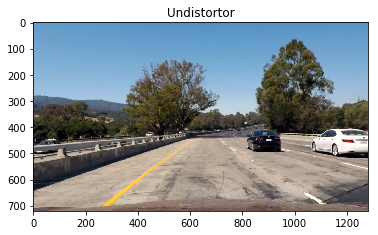

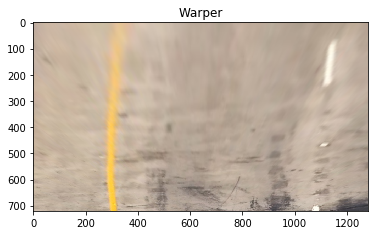

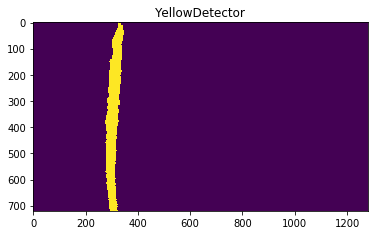

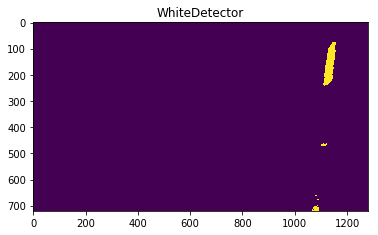

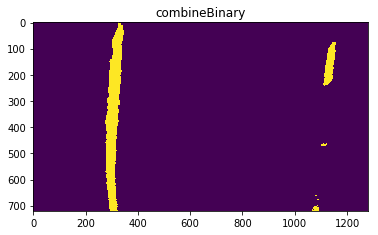

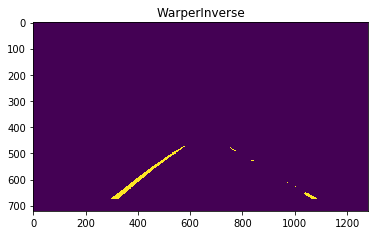

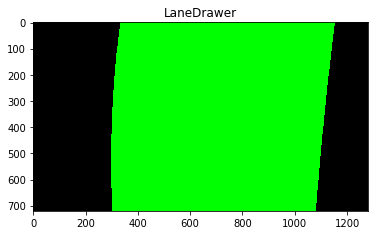

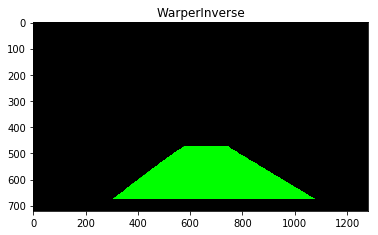

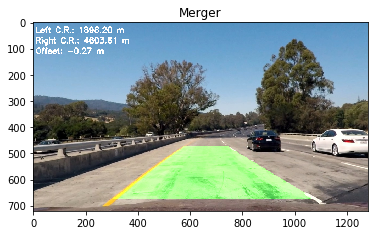

In [5]:
image = cv2.imread('./test_images/test1.jpg')[:,:,::-1]
test = Test(show=True)
test(image)

# test some frames

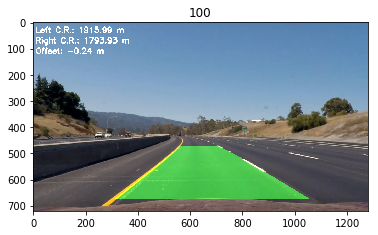

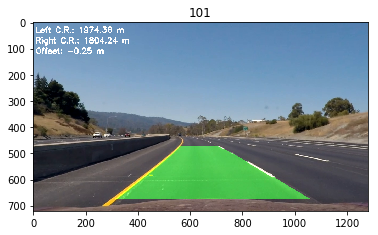

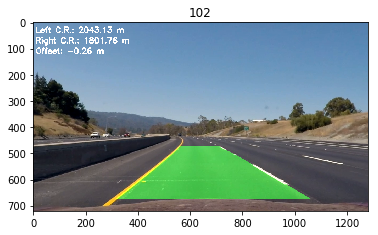

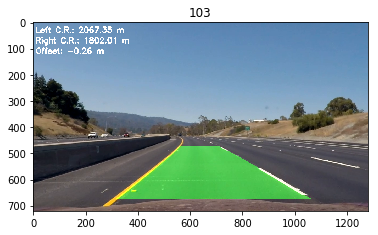

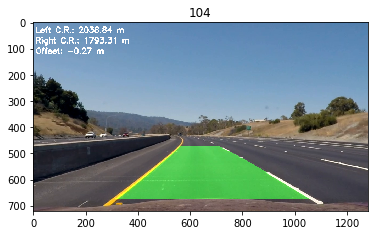

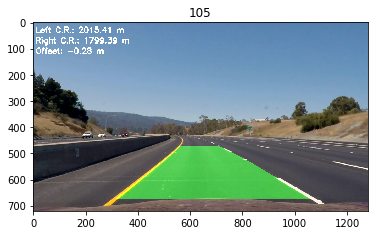

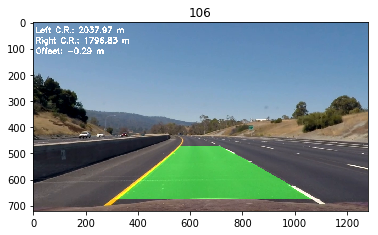

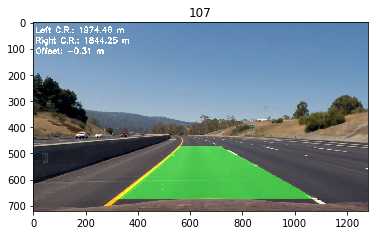

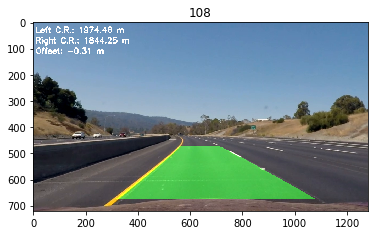

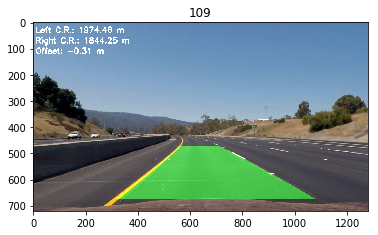

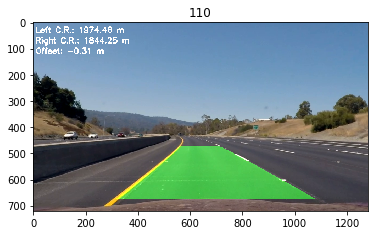

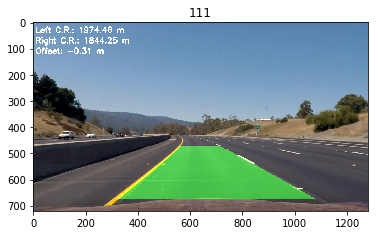

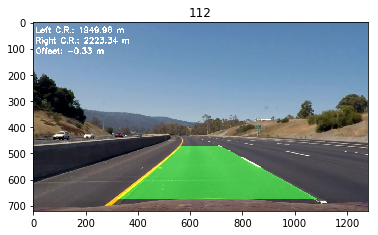

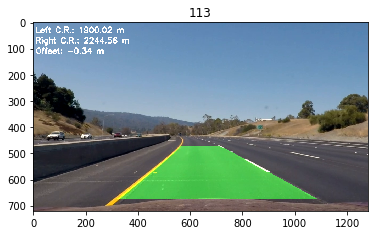

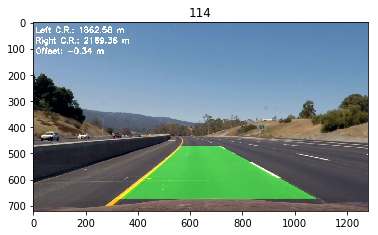

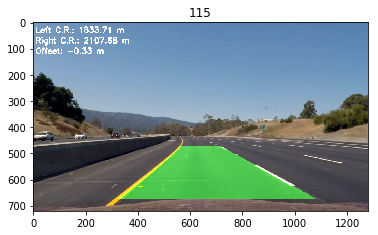

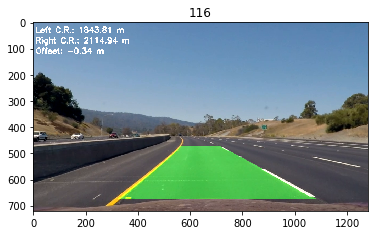

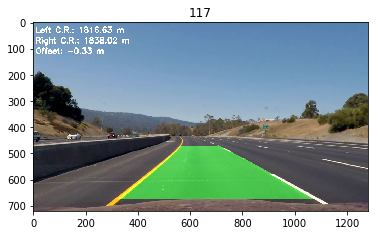

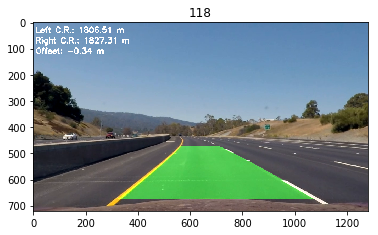

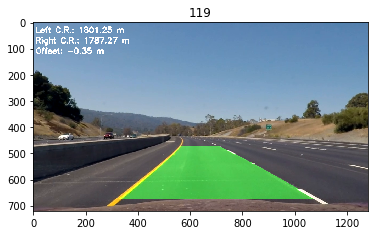

In [12]:
import pylab
import imageio
test = Test(show=False)
filename = 'project_video.mp4'
vid = imageio.get_reader(filename,  'ffmpeg')
for num in range(100,120):
    image = vid.get_data(num)
    result = test(image)
    plt.figure(num)
    plt.title("%d" % num)
    plt.imshow(result)

# test project_video.mp4

In [5]:
from moviepy.editor import VideoFileClip
test = Test()
white_output = 'output_videos/project_video.mp4'
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(test)
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [06:28<00:00,  2.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 



In [6]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

# test challenge_video.mp4

In [15]:
test2 = Test()
white_output = 'output_videos/challenge_video.mp4'
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip('challenge_video.mp4')
white_clip = clip1.fl_image(test2)
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4




  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 1/485 [00:00<01:24,  5.72it/s]

  0%|          | 2/485 [00:00<01:37,  4.93it/s]

  1%|          | 3/485 [00:00<01:44,  4.60it/s]

  1%|          | 4/485 [00:00<01:48,  4.43it/s]

  1%|          | 5/485 [00:01<01:50,  4.33it/s]

  1%|          | 6/485 [00:01<01:52,  4.26it/s]

  1%|▏         | 7/485 [00:01<01:54,  4.19it/s]

  2%|▏         | 8/485 [00:01<01:54,  4.16it/s]

  2%|▏         | 9/485 [00:02<01:56,  4.08it/s]

  2%|▏         | 10/485 [00:02<01:55,  4.11it/s]

  2%|▏         | 11/485 [00:02<01:54,  4.12it/s]

  2%|▏         | 12/485 [00:02<01:54,  4.14it/s]

  3%|▎         | 13/485 [00:03<01:53,  4.15it/s]

  3%|▎         | 14/485 [00:03<01:54,  4.11it/s]

  3%|▎         | 15/485 [00:03<01:53,  4.15it/s]

  3%|▎         | 16/485 [00:03<01:52,  4.15it/s]

  4%|▎         | 17/485 [00:04<01:53,  4.12it/s]

  4%|▎         | 18/485 [00:04<01:54,  4.09it/s]

  4%|▍         | 19/485 [00:04<01:53,  4.11it/s]

  4%|▍         |

 30%|██▉       | 145/485 [00:43<01:46,  3.19it/s]

 30%|███       | 146/485 [00:43<01:49,  3.09it/s]

 30%|███       | 147/485 [00:44<01:49,  3.10it/s]

 31%|███       | 148/485 [00:44<01:51,  3.02it/s]

 31%|███       | 149/485 [00:44<01:49,  3.07it/s]

 31%|███       | 150/485 [00:45<01:52,  2.97it/s]

 31%|███       | 151/485 [00:45<01:50,  3.03it/s]

 31%|███▏      | 152/485 [00:45<01:52,  2.95it/s]

 32%|███▏      | 153/485 [00:46<01:50,  3.00it/s]

 32%|███▏      | 154/485 [00:46<01:53,  2.92it/s]

 32%|███▏      | 155/485 [00:46<01:50,  2.99it/s]

 32%|███▏      | 156/485 [00:47<01:52,  2.92it/s]

 32%|███▏      | 157/485 [00:47<01:48,  3.01it/s]

 33%|███▎      | 158/485 [00:47<01:50,  2.97it/s]

 33%|███▎      | 159/485 [00:48<01:54,  2.85it/s]

 33%|███▎      | 160/485 [00:48<01:52,  2.88it/s]

 33%|███▎      | 161/485 [00:48<01:52,  2.89it/s]

 33%|███▎      | 162/485 [00:49<01:50,  2.91it/s]

 34%|███▎      | 163/485 [00:49<01:50,  2.92it/s]

 34%|███▍      | 164/485 [00:49

 59%|█████▉    | 288/485 [01:30<00:59,  3.29it/s]

 60%|█████▉    | 289/485 [01:31<01:03,  3.10it/s]

 60%|█████▉    | 290/485 [01:31<01:02,  3.13it/s]

 60%|██████    | 291/485 [01:31<01:00,  3.20it/s]

 60%|██████    | 292/485 [01:32<00:59,  3.25it/s]

 60%|██████    | 293/485 [01:32<01:00,  3.18it/s]

 61%|██████    | 294/485 [01:32<00:59,  3.21it/s]

 61%|██████    | 295/485 [01:33<00:57,  3.28it/s]

 61%|██████    | 296/485 [01:33<00:56,  3.37it/s]

 61%|██████    | 297/485 [01:33<00:59,  3.15it/s]

 61%|██████▏   | 298/485 [01:34<00:59,  3.14it/s]

 62%|██████▏   | 299/485 [01:34<00:57,  3.26it/s]

 62%|██████▏   | 300/485 [01:34<00:55,  3.32it/s]

 62%|██████▏   | 301/485 [01:35<00:58,  3.15it/s]

 62%|██████▏   | 302/485 [01:35<00:57,  3.20it/s]

 62%|██████▏   | 303/485 [01:35<00:55,  3.25it/s]

 63%|██████▎   | 304/485 [01:35<00:56,  3.18it/s]

 63%|██████▎   | 305/485 [01:36<00:57,  3.13it/s]

 63%|██████▎   | 306/485 [01:36<00:56,  3.17it/s]

 63%|██████▎   | 307/485 [01:36

 89%|████████▉ | 431/485 [02:16<00:17,  3.10it/s]

 89%|████████▉ | 432/485 [02:17<00:16,  3.14it/s]

 89%|████████▉ | 433/485 [02:17<00:17,  3.04it/s]

 89%|████████▉ | 434/485 [02:17<00:16,  3.15it/s]

 90%|████████▉ | 435/485 [02:18<00:16,  3.05it/s]

 90%|████████▉ | 436/485 [02:18<00:15,  3.13it/s]

 90%|█████████ | 437/485 [02:18<00:15,  3.19it/s]

 90%|█████████ | 438/485 [02:19<00:15,  3.07it/s]

 91%|█████████ | 439/485 [02:19<00:14,  3.08it/s]

 91%|█████████ | 440/485 [02:19<00:14,  3.15it/s]

 91%|█████████ | 441/485 [02:20<00:14,  3.02it/s]

 91%|█████████ | 442/485 [02:20<00:13,  3.09it/s]

 91%|█████████▏| 443/485 [02:20<00:13,  3.14it/s]

 92%|█████████▏| 444/485 [02:21<00:13,  3.04it/s]

 92%|█████████▏| 445/485 [02:21<00:12,  3.12it/s]

 92%|█████████▏| 446/485 [02:21<00:12,  3.17it/s]

 92%|█████████▏| 447/485 [02:21<00:12,  3.04it/s]

 92%|█████████▏| 448/485 [02:22<00:11,  3.09it/s]

 93%|█████████▎| 449/485 [02:22<00:11,  3.13it/s]

 93%|█████████▎| 450/485 [02:22

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 



In [16]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

# test harder_challenge_video.mp4

In [17]:
test3 = Test()
white_output = 'output_videos/harder_challenge_video.mp4'
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip('harder_challenge_video.mp4')
white_clip = clip1.fl_image(test3)
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/harder_challenge_video.mp4
[MoviePy] Writing video output_videos/harder_challenge_video.mp4




  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 1/1200 [00:00<04:00,  4.99it/s]

  0%|          | 2/1200 [00:00<04:11,  4.76it/s]

  0%|          | 3/1200 [00:00<04:12,  4.74it/s]

  0%|          | 4/1200 [00:00<04:13,  4.71it/s]

  0%|          | 5/1200 [00:01<04:13,  4.71it/s]

  0%|          | 6/1200 [00:01<04:13,  4.71it/s]

  1%|          | 7/1200 [00:01<04:07,  4.82it/s]

  1%|          | 8/1200 [00:01<04:05,  4.85it/s]

  1%|          | 9/1200 [00:01<04:32,  4.38it/s]

  1%|          | 10/1200 [00:02<04:50,  4.10it/s]

  1%|          | 11/1200 [00:02<05:03,  3.92it/s]

  1%|          | 12/1200 [00:02<05:10,  3.83it/s]

  1%|          | 13/1200 [00:03<05:12,  3.80it/s]

  1%|          | 14/1200 [00:03<05:15,  3.76it/s]

  1%|▏         | 15/1200 [00:03<05:24,  3.65it/s]

  1%|▏         | 16/1200 [00:03<05:23,  3.66it/s]

  1%|▏         | 17/1200 [00:04<05:24,  3.65it/s]

  2%|▏         | 18/1200 [00:04<05:25,  3.63it/s]

  2%|▏         | 19/1200 [00:04<05:25,  3.63it/

 12%|█▏        | 143/1200 [00:49<06:32,  2.69it/s]

 12%|█▏        | 144/1200 [00:49<06:41,  2.63it/s]

 12%|█▏        | 145/1200 [00:49<06:25,  2.73it/s]

 12%|█▏        | 146/1200 [00:50<06:29,  2.70it/s]

 12%|█▏        | 147/1200 [00:50<06:39,  2.64it/s]

 12%|█▏        | 148/1200 [00:50<06:26,  2.72it/s]

 12%|█▏        | 149/1200 [00:51<06:38,  2.63it/s]

 12%|█▎        | 150/1200 [00:51<06:28,  2.70it/s]

 13%|█▎        | 151/1200 [00:52<06:38,  2.63it/s]

 13%|█▎        | 152/1200 [00:52<06:30,  2.68it/s]

 13%|█▎        | 153/1200 [00:52<06:38,  2.62it/s]

 13%|█▎        | 154/1200 [00:53<06:24,  2.72it/s]

 13%|█▎        | 155/1200 [00:53<06:34,  2.65it/s]

 13%|█▎        | 156/1200 [00:53<06:20,  2.74it/s]

 13%|█▎        | 157/1200 [00:54<06:31,  2.66it/s]

 13%|█▎        | 158/1200 [00:54<06:22,  2.72it/s]

 13%|█▎        | 159/1200 [00:54<06:28,  2.68it/s]

 13%|█▎        | 160/1200 [00:55<06:15,  2.77it/s]

 13%|█▎        | 161/1200 [00:55<06:23,  2.71it/s]

 14%|█▎     

 24%|██▎       | 284/1200 [01:41<06:05,  2.51it/s]

 24%|██▍       | 285/1200 [01:41<05:57,  2.56it/s]

 24%|██▍       | 286/1200 [01:42<06:14,  2.44it/s]

 24%|██▍       | 287/1200 [01:42<06:05,  2.50it/s]

 24%|██▍       | 288/1200 [01:43<05:54,  2.58it/s]

 24%|██▍       | 289/1200 [01:43<06:08,  2.47it/s]

 24%|██▍       | 290/1200 [01:43<06:05,  2.49it/s]

 24%|██▍       | 291/1200 [01:44<05:58,  2.53it/s]

 24%|██▍       | 292/1200 [01:44<05:52,  2.58it/s]

 24%|██▍       | 293/1200 [01:45<05:48,  2.60it/s]

 24%|██▍       | 294/1200 [01:45<05:48,  2.60it/s]

 25%|██▍       | 295/1200 [01:45<05:46,  2.61it/s]

 25%|██▍       | 296/1200 [01:46<05:51,  2.57it/s]

 25%|██▍       | 297/1200 [01:46<05:41,  2.64it/s]

 25%|██▍       | 298/1200 [01:46<05:43,  2.62it/s]

 25%|██▍       | 299/1200 [01:47<05:43,  2.63it/s]

 25%|██▌       | 300/1200 [01:47<05:41,  2.64it/s]

 25%|██▌       | 301/1200 [01:48<05:42,  2.63it/s]

 25%|██▌       | 302/1200 [01:48<05:42,  2.62it/s]

 25%|██▌    

 35%|███▌      | 425/1200 [02:44<05:44,  2.25it/s]

 36%|███▌      | 426/1200 [02:44<05:47,  2.23it/s]

 36%|███▌      | 427/1200 [02:45<05:34,  2.31it/s]

 36%|███▌      | 428/1200 [02:45<05:36,  2.29it/s]

 36%|███▌      | 429/1200 [02:46<05:34,  2.31it/s]

 36%|███▌      | 430/1200 [02:46<05:19,  2.41it/s]

 36%|███▌      | 431/1200 [02:46<05:31,  2.32it/s]

 36%|███▌      | 432/1200 [02:47<05:23,  2.37it/s]

 36%|███▌      | 433/1200 [02:47<05:44,  2.23it/s]

 36%|███▌      | 434/1200 [02:48<05:36,  2.28it/s]

 36%|███▋      | 435/1200 [02:48<05:25,  2.35it/s]

 36%|███▋      | 436/1200 [02:49<05:36,  2.27it/s]

 36%|███▋      | 437/1200 [02:49<05:18,  2.40it/s]

 36%|███▋      | 438/1200 [02:49<05:13,  2.43it/s]

 37%|███▋      | 439/1200 [02:50<05:15,  2.41it/s]

 37%|███▋      | 440/1200 [02:50<05:23,  2.35it/s]

 37%|███▋      | 441/1200 [02:51<05:10,  2.45it/s]

 37%|███▋      | 442/1200 [02:51<05:02,  2.51it/s]

 37%|███▋      | 443/1200 [02:51<05:10,  2.44it/s]

 37%|███▋   

 47%|████▋     | 566/1200 [03:36<03:32,  2.99it/s]

 47%|████▋     | 567/1200 [03:37<03:27,  3.05it/s]

 47%|████▋     | 568/1200 [03:37<03:35,  2.93it/s]

 47%|████▋     | 569/1200 [03:37<03:28,  3.03it/s]

 48%|████▊     | 570/1200 [03:38<03:35,  2.93it/s]

 48%|████▊     | 571/1200 [03:38<03:26,  3.05it/s]

 48%|████▊     | 572/1200 [03:38<03:30,  2.98it/s]

 48%|████▊     | 573/1200 [03:39<03:33,  2.94it/s]

 48%|████▊     | 574/1200 [03:39<03:27,  3.01it/s]

 48%|████▊     | 575/1200 [03:39<03:31,  2.95it/s]

 48%|████▊     | 576/1200 [03:40<03:23,  3.07it/s]

 48%|████▊     | 577/1200 [03:40<03:28,  2.98it/s]

 48%|████▊     | 578/1200 [03:40<03:24,  3.05it/s]

 48%|████▊     | 579/1200 [03:41<03:25,  3.03it/s]

 48%|████▊     | 580/1200 [03:41<03:27,  2.99it/s]

 48%|████▊     | 581/1200 [03:41<03:27,  2.99it/s]

 48%|████▊     | 582/1200 [03:42<03:27,  2.98it/s]

 49%|████▊     | 583/1200 [03:42<03:31,  2.92it/s]

 49%|████▊     | 584/1200 [03:42<03:14,  3.17it/s]

 49%|████▉  

 59%|█████▉    | 707/1200 [04:35<02:53,  2.84it/s]

 59%|█████▉    | 708/1200 [04:36<02:52,  2.85it/s]

 59%|█████▉    | 709/1200 [04:36<02:51,  2.86it/s]

 59%|█████▉    | 710/1200 [04:36<02:50,  2.87it/s]

 59%|█████▉    | 711/1200 [04:37<02:50,  2.86it/s]

 59%|█████▉    | 712/1200 [04:37<02:45,  2.95it/s]

 59%|█████▉    | 713/1200 [04:37<02:45,  2.94it/s]

 60%|█████▉    | 714/1200 [04:38<03:02,  2.66it/s]

 60%|█████▉    | 715/1200 [04:38<03:04,  2.62it/s]

 60%|█████▉    | 716/1200 [04:39<03:07,  2.58it/s]

 60%|█████▉    | 717/1200 [04:39<03:13,  2.49it/s]

 60%|█████▉    | 718/1200 [04:39<03:07,  2.57it/s]

 60%|█████▉    | 719/1200 [04:40<02:52,  2.79it/s]

 60%|██████    | 720/1200 [04:40<02:50,  2.82it/s]

 60%|██████    | 721/1200 [04:40<02:53,  2.75it/s]

 60%|██████    | 722/1200 [04:41<03:05,  2.57it/s]

 60%|██████    | 723/1200 [04:41<03:10,  2.50it/s]

 60%|██████    | 724/1200 [04:42<03:02,  2.61it/s]

 60%|██████    | 725/1200 [04:42<02:57,  2.68it/s]

 60%|██████ 

 71%|███████   | 848/1200 [05:34<02:43,  2.15it/s]

 71%|███████   | 849/1200 [05:34<02:44,  2.14it/s]

 71%|███████   | 850/1200 [05:35<02:46,  2.10it/s]

 71%|███████   | 851/1200 [05:35<02:48,  2.07it/s]

 71%|███████   | 852/1200 [05:36<02:51,  2.03it/s]

 71%|███████   | 853/1200 [05:37<03:00,  1.92it/s]

 71%|███████   | 854/1200 [05:37<03:11,  1.80it/s]

 71%|███████▏  | 855/1200 [05:38<03:10,  1.81it/s]

 71%|███████▏  | 856/1200 [05:38<03:13,  1.77it/s]

 71%|███████▏  | 857/1200 [05:39<03:16,  1.74it/s]

 72%|███████▏  | 858/1200 [05:40<03:27,  1.64it/s]

 72%|███████▏  | 859/1200 [05:40<03:24,  1.66it/s]

 72%|███████▏  | 860/1200 [05:41<03:21,  1.69it/s]

 72%|███████▏  | 861/1200 [05:41<03:18,  1.71it/s]

 72%|███████▏  | 862/1200 [05:42<03:28,  1.62it/s]

 72%|███████▏  | 863/1200 [05:43<03:17,  1.71it/s]

 72%|███████▏  | 864/1200 [05:43<03:06,  1.80it/s]

 72%|███████▏  | 865/1200 [05:44<03:22,  1.65it/s]

 72%|███████▏  | 866/1200 [05:44<03:08,  1.77it/s]

 72%|███████

 82%|████████▏ | 989/1200 [06:38<01:12,  2.90it/s]

 82%|████████▎ | 990/1200 [06:38<01:15,  2.78it/s]

 83%|████████▎ | 991/1200 [06:38<01:11,  2.92it/s]

 83%|████████▎ | 992/1200 [06:39<01:12,  2.86it/s]

 83%|████████▎ | 993/1200 [06:39<01:09,  2.98it/s]

 83%|████████▎ | 994/1200 [06:39<01:10,  2.90it/s]

 83%|████████▎ | 995/1200 [06:40<01:08,  3.00it/s]

 83%|████████▎ | 996/1200 [06:40<01:09,  2.92it/s]

 83%|████████▎ | 997/1200 [06:40<01:07,  3.02it/s]

 83%|████████▎ | 998/1200 [06:41<01:08,  2.93it/s]

 83%|████████▎ | 999/1200 [06:41<01:06,  3.02it/s]

 83%|████████▎ | 1000/1200 [06:41<01:08,  2.93it/s]

 83%|████████▎ | 1001/1200 [06:42<01:05,  3.02it/s]

 84%|████████▎ | 1002/1200 [06:42<01:05,  3.01it/s]

 84%|████████▎ | 1003/1200 [06:42<01:07,  2.92it/s]

 84%|████████▎ | 1004/1200 [06:43<01:05,  3.00it/s]

 84%|████████▍ | 1005/1200 [06:43<01:06,  2.94it/s]

 84%|████████▍ | 1006/1200 [06:43<01:03,  3.06it/s]

 84%|████████▍ | 1007/1200 [06:44<01:05,  2.96it/s]

 84%

 94%|█████████▍| 1128/1200 [07:33<00:25,  2.84it/s]

 94%|█████████▍| 1129/1200 [07:33<00:24,  2.95it/s]

 94%|█████████▍| 1130/1200 [07:33<00:24,  2.88it/s]

 94%|█████████▍| 1131/1200 [07:34<00:23,  2.99it/s]

 94%|█████████▍| 1132/1200 [07:34<00:23,  2.87it/s]

 94%|█████████▍| 1133/1200 [07:34<00:22,  2.98it/s]

 94%|█████████▍| 1134/1200 [07:35<00:22,  2.89it/s]

 95%|█████████▍| 1135/1200 [07:35<00:22,  2.83it/s]

 95%|█████████▍| 1136/1200 [07:36<00:21,  2.91it/s]

 95%|█████████▍| 1137/1200 [07:36<00:23,  2.69it/s]

 95%|█████████▍| 1138/1200 [07:36<00:22,  2.80it/s]

 95%|█████████▍| 1139/1200 [07:37<00:23,  2.64it/s]

 95%|█████████▌| 1140/1200 [07:37<00:21,  2.74it/s]

 95%|█████████▌| 1141/1200 [07:37<00:22,  2.59it/s]

 95%|█████████▌| 1142/1200 [07:38<00:21,  2.70it/s]

 95%|█████████▌| 1143/1200 [07:38<00:21,  2.64it/s]

 95%|█████████▌| 1144/1200 [07:39<00:20,  2.75it/s]

 95%|█████████▌| 1145/1200 [07:39<00:20,  2.68it/s]

 96%|█████████▌| 1146/1200 [07:39<00:20,  2.61

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video.mp4 



In [18]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))